# User behavior in health tracking app

## Data source:
#### Subset of data which only has users who inputed their weight at least 2 times. However, there are still null or zero values.
- stats.txt contains each user's app attributes
- weights.txt contains multiple weight entries for each user ID

In order to understand how the app is serving the users, we need input from the user. In this data, we will be looking for:
- number of times the user inputs their weight (goal tracking)
- when they input their weight: frequency, when they started tracking compared to when the app was installed
- what other factors influence if they goal track or reach their goal i.e. who reaches their goals?

To dos:

In [3]:
# need to standardize date format to yyyy-mm-dd from yyyy-m-d --> Done
# where are the zero values?
# add column to tally how many parameters the user inputted
# add BMI

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('stats.txt', delimiter='\t')

In [4]:
df.head(2)

,ID,InstallDate,LastSavedUTC,FirstInstalledVersion,SessionCount,ExperimentID,UICulture,Language,IsPaid,LastPurchaseDaysSinceInstall,...,DailyGoalCount,Program,ReminderFrequency,SelectedTotal,ShowMealTime,ExerciseFrequency,Height,StartingWeight,TargetWeight,OnboardingGoal
0,1,2018-04-28,2019-03-21,4.4.3,590,2106,en-CA,en,False,NaN,...,4,Normal,ForEveryMeal,Calories,False,LittleOrNone,168.91,90.08356,86.18266,LoseMaintainOrGainWeight
1,2,2018-01-23,2018-08-01,3.6.3.1,253,607,de-DE,de,True,25.0,...,4,Normal,ForEveryMeal,Calories,True,LittleOrNone,178.00,100.00000,80.00000,LoseMaintainOrGainWeight


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86796 entries, 0 to 86795
Data columns (total 24 columns):
ID                              86796 non-null int64
InstallDate                     86796 non-null object
LastSavedUTC                    86796 non-null object
FirstInstalledVersion           86785 non-null object
SessionCount                    86796 non-null int64
ExperimentID                    86796 non-null int64
UICulture                       86796 non-null object
Language                        86796 non-null object
IsPaid                          86796 non-null bool
LastPurchaseDaysSinceInstall    3961 non-null float64
Feedback.FirstRating            37542 non-null float64
Feedback.RatingCount            54386 non-null float64
Gender                          86796 non-null object
AgeWhenGoalsSet                 86796 non-null int64
DailyGoalCount                  86796 non-null int64
Program                         86796 non-null object
ReminderFrequency               

In [16]:
# Drop unnecessary column(s)

df = df.drop('ExperimentID', axis=1)

In [17]:
# Change date strings into datetime objects

df['InstallDate'] = pd.to_datetime(df['InstallDate'])
df['LastSavedUTC'] = pd.to_datetime(df['LastSavedUTC'], errors='coerce')

In [19]:
# Replace string 'none' to None for Gender

df['Gender'].replace('None', None);

## Feature Engineering
Create new interaction features:
- Inputs: count the number of inputs the user inputted as a measure for user engagement in the app
- Inputs_pct: percentage of inputs completed by user
- Body Mass Index (BMI): measure of fitness (weight/height$^2$ in kg/m$^2$)

Handle columns with sparse distribution in categories:
- Age: rather than use a continuous integer value, we can also create a new column for age group (quintiles based on distribution)
- Onboarding Goal: consolidate 8 categories into fewer categories

In [101]:
# Re-assign OnboardingGoal categories into fewer categories
cats = {'weight':['LoseMaintainOrGainWeight'], 
        'nutrition':['TrackSpecificNutritionGoals'], 
        'none':['Skip', 'NotOffered', 'None', 'SignIn'],
        'other':['Other', 'JustCurious']}

cats2 = {v: k for k,vv in cats.items() for v in vv}

In [102]:
df['OnboardingGoal'] = df['OnboardingGoal'].map(cats2).astype('category')

In [103]:
df['OnboardingGoal'].value_counts()

weight       77078
other         3829
nutrition     2980
none          2909
Name: OnboardingGoal, dtype: int64

In [104]:
# Inputs
# Create new column in dataframe
df['Inputs'] = 0

In [106]:
# If the user input meets the condition for each feature, add 1 to the input count

for idx in df.index:
    
    if df.at[idx, 'Gender']!='None':
        df.at[idx, 'Inputs'] += 1
        
    if df.at[idx, 'AgeWhenGoalsSet']!=0:
        df.at[idx, 'Inputs'] += 1
        
    if df.at[idx, 'Program']!='None':
        df.at[idx, 'Inputs'] += 1
        
    if (df.at[idx, 'ReminderFrequency']=='ForEveryMeal') | (df.at[idx, 'ReminderFrequency']=='OncePerDay'):
        df.at[idx, 'Inputs'] += 1
        
    if df.at[idx, 'ShowMealTime']==True:
        df.at[idx, 'Inputs'] += 1
        
    if df.at[idx, 'Height']!=0:
        df.at[idx, 'Inputs'] += 1
    
    if df.at[idx, 'StartingWeight']!=0:
        df.at[idx, 'Inputs'] += 1
              
    if df.at[idx, 'TargetWeight']!=0:
        df.at[idx, 'Inputs'] += 1
              
    if df.at[idx, 'OnboardingGoal']!='none':
        df.at[idx, 'Inputs'] += 1

In [109]:
# Inputs_pct is the percentage of inputs completion for each user (9 inputs total)

total_inputs = 9
df['Inputs_pct'] = (df['Inputs']/total_inputs).astype(float)

In [ ]:
# BMI calculated from weight and height

df['BMI'] = df['StartingWeight']/(df['Height']/100)**2

### AgeWhenGoalsSet
- minimum age for Itunes and Google Play stores are 13 years old
- some entries < 13 yo (6-12 yo)

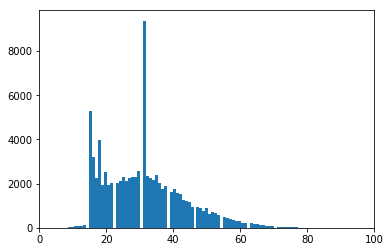

In [142]:
plt.hist(df['AgeWhenGoalsSet'], bins=100)
plt.xlim(0,100);
plt.show()

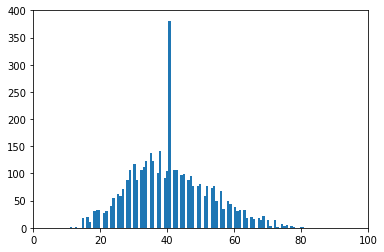

In [143]:
plt.hist(df[df['IsPaid']==True]['AgeWhenGoalsSet'], bins=100)
plt.xlim(0,100)
plt.show()

In [144]:
# users who have paid for the app tend to be older
df[(df['IsPaid']==True) & (df['AgeWhenGoalsSet']!=0)]['AgeWhenGoalsSet'].describe()

count    3961.000000
mean       40.887402
std        11.983319
min        11.000000
25%        32.000000
50%        41.000000
75%        48.000000
max        81.000000
Name: AgeWhenGoalsSet, dtype: float64

In [145]:
df[(df['IsPaid']==False) & (df['AgeWhenGoalsSet']!=0)]['AgeWhenGoalsSet'].describe()

count    82835.000000
mean        30.794399
std         11.688871
min          6.000000
25%         21.000000
50%         31.000000
75%         37.000000
max         95.000000
Name: AgeWhenGoalsSet, dtype: float64

In [ ]:
# for age, split into paid and not paid, then take mean from each category

avg_age_paid = 41
avg_age_notpaid = 31

df.loc[(df['IsPaid']==True) & (df['AgeWhenGoalsSet']==0), 'AgeWhenGoalsSet'] = avg_age_paid
df.loc[(df['IsPaid']==False) & (df['AgeWhenGoalsSet']==0), 'AgeWhenGoalsSet'] = avg_age_notpaid

In [146]:
df.to_pickle('df_190419.pkl')